In [1]:
#Install packages 
!pip install -q datasets 
!pip install tqdm --upgrade 
!pip install pillow 
!pip install torchvision 
!pip install -q git+https://github.com/huggingface/transformers.git

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.6 MB 11.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.7/2.6 MB 9.5 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 8.7 MB/s eta 0:00:01
   ------------------------ --------------- 1.5/2.6 MB 8.9 MB/s eta 0:00:01
   ----------------------------- ---------- 1.9/2.6 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------  2.5/2.6 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 9.1 MB/s eta 0:00:00
  Using cached MarkupSafe-2.1.5-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------------- ------------------------- 0.4/1.2 MB 9.3 MB/s eta 0:00:01
   ------------------------- -------------- 0.7/1.2 MB 9.5 MB/s eta 0:00:01
   -----------------------------------

In [11]:
# Imports 
import os 
import json 
import torch 
from datasets import load_dataset 
from tqdm.notebook import tqdm 
from torch.utils.data import Dataset, DataLoader 
from transformers import AutoProcessor, AutoModelForCausalLM

In [2]:
# Defining data paths 
DATA_PATHS = {
    "raw_dataset_path": "dataset/", 
    "image_set_path": "complete_image_set/train"
}

#### Create metadata.jsonl file 

The dataset is organized as directed on the huggingface documentation on creating an image dataset https://huggingface.co/docs/datasets/v2.7.1/en/image_dataset
    
Captions structure :

    [{file_name: "404/404.png", "prompt": "This is a 404 page design"}]

In [3]:
captions = []
for category in os.listdir(DATA_PATHS["raw_dataset_path"]): 
    for file in os.listdir(f"{DATA_PATHS['raw_dataset_path']}/{category}/images/"):
        with open(f"{DATA_PATHS['raw_dataset_path']}/{category}/prompts/{file.split('.')[0]}.txt", "r") as f: 
            prompts = f.readlines()

            for prompt in prompts: 
                captions.append({"file_name": f"{category}/{file}", "prompts": prompt.split('\n')[0]})

In [4]:
# add metadata.jsonl file to this folder
with open(f"{DATA_PATHS['image_set_path']}/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

### Define and Preprocess Datasets 

In [5]:
dataset = load_dataset("imagefolder", data_dir=DATA_PATHS["image_set_path"], split="train", drop_labels=False)

Generating train split: 120 examples [00:00, 799.75 examples/s]


In [6]:
dataset

Dataset({
    features: ['image', 'label', 'prompts'],
    num_rows: 120
})

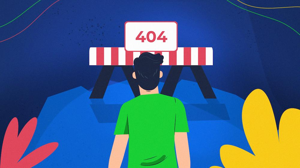

In [7]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [10]:
example["prompts"]

'404 page with cartoonish vibe'

In [12]:
processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [13]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.max_text_length=512

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["prompts"], padding="max_length", return_tensors="pt")
                                                          
        # Remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding     

In [14]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [15]:
item = train_dataset[0]
for k,v in item.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [16]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [18]:
processor.decode(batch["input_ids"][0])

'[CLS] neat about us page design with cartoon illustrations, a navbar and intelligent use of white space and padding [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

### Fine-tuning

In [19]:
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [20]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.9096, grad_fn=<NllLossBackward0>)

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

Epoch: 0
Loss: 7.699113368988037
Loss: 7.683717727661133
Loss: 7.510069370269775
Loss: 7.420686721801758
Loss: 7.346508026123047
Loss: 7.213692665100098
Loss: 7.190284252166748
Loss: 7.085061550140381
Loss: 6.9610700607299805
Loss: 6.857726097106934
Loss: 6.780704975128174
Loss: 6.664550304412842
Loss: 6.551970958709717
Loss: 6.4481706619262695
Loss: 6.3224406242370605
Loss: 6.248832702636719
Loss: 6.17200231552124
Loss: 5.995654106140137
Loss: 5.9395270347595215
Loss: 5.835883617401123
Loss: 5.743439197540283
Loss: 5.653208255767822
Loss: 5.530881404876709
Loss: 5.438432216644287
Loss: 5.299572467803955
Loss: 5.219832897186279
Loss: 5.078723907470703
Loss: 5.02031135559082
Loss: 4.923350811004639
Loss: 4.7863311767578125
Loss: 4.695322036743164
Loss: 4.60723352432251
Loss: 4.483130931854248
Loss: 4.43522834777832
Loss: 4.334080219268799
Loss: 4.144602298736572
Loss: 4.056463241577148
Loss: 3.9714460372924805
Loss: 3.9013075828552246
Loss: 3.740849733352661
Loss: 3.645277500152588
Loss

Loss: 0.051819734275341034
Loss: 0.05003033205866814
Loss: 0.04125730320811272
Loss: 0.04717724025249481
Loss: 0.03977585211396217
Loss: 0.04610646888613701
Loss: 0.04321759194135666
Loss: 0.04579981043934822
Loss: 0.06603246182203293
Loss: 0.04454409331083298
Loss: 0.039998214691877365
Loss: 0.027698248624801636
Loss: 0.05638933181762695
Loss: 0.051152072846889496
Loss: 0.05688626319169998
Loss: 0.05042541027069092
Loss: 0.04523512348532677
Loss: 0.06113480031490326
Loss: 0.03924403339624405
Loss: 0.054382771253585815
Loss: 0.041815098375082016
Loss: 0.032422006130218506
Loss: 0.04511808231472969
Loss: 0.046446580439805984
Loss: 0.05360822007060051
Loss: 0.03265690803527832
Loss: 0.03734796121716499
Loss: 0.04473450779914856
Loss: 0.0516190379858017
Loss: 0.03833194077014923
Loss: 0.04968634992837906
Loss: 0.05561947450041771
Loss: 0.06426620483398438
Loss: 0.032779693603515625
Loss: 0.04103933274745941
Loss: 0.08003942668437958
Loss: 0.06023770198225975
Loss: 0.05734650790691376
Loss

### Inference

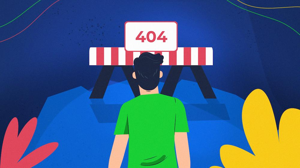

In [23]:
# load image
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [24]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

animated blob shaped illustration based 404 page design with a purple and white color scheme
